In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import sys
sys.path.append('../')

import pandas as pd

from UpStraight_Train import evaluate_model, ColumnSelector, get_training_weights, training_columns

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline

In [6]:
train = pd.read_csv("../data/train.csv")

In [7]:
train.shape

(467, 44)

In [8]:
# still focused on posture prediction
train["posture"] = train["posture"].map({-1:0,1:1,0:0})

In [9]:
prep = train.dropna()
prep.shape

(323, 44)

In [23]:
y = prep["posture"]
X = prep.drop("posture",axis=1)
y_stratification = pd.concat([y,X["source"]],axis=1)
y_stratification.shape

(323, 2)

In [21]:
prep.source.value_counts()

cr      93
lass    84
dotz    71
as      52
far     23
Name: source, dtype: int64

In [26]:
# train a Logistic Regression
def train_user_log_reg_cv(prep, source, target_weight = 0.7, test_size = 0.2):
    y = prep["posture"]
    X = prep.drop("posture",axis=1)
    # map source to 1 else 0
    X["source"] = X["source"].map(lambda x: 1 if x==source else 0)
    # param grid for log reg
    param_grid = {"clf__penalty":["l1","l2"], "clf__C": [0.001,0.01,0.1,1,10,100,1000]}
    custom_cv = StratifiedShuffleSplit(n_splits=4,test_size=test_size,random_state=42)
    # use source as additional variable in making splits to ensure that source data points are in each split
    y_stratification = pd.concat([y,X["source"]],axis=1)
    splits = custom_cv.split(X,y_stratification)
    rf_grid = GridSearchCV(Pipeline([("col_selector",ColumnSelector(columns=training_columns)),("clf",LogisticRegression())]),param_grid=param_grid,cv=splits,verbose=1,n_jobs=-1)
    rf_results = rf_grid.fit(X,y,clf__sample_weight= get_training_weights(X,target=target_weight))
    return rf_results


In [39]:
reg = train_user_log_reg_cv(prep, "lass")
best_reg = reg.best_estimator_

Fitting 4 folds for each of 14 candidates, totalling 56 fits


/Users/lasse/miniconda3/envs/eda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lasse/miniconda3/envs/eda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

              precision    recall  f1-score   support

           0       0.88      0.47      0.61        30
           1       0.76      0.96      0.85        54

    accuracy                           0.79        84
   macro avg       0.82      0.71      0.73        84
weighted avg       0.80      0.79      0.77        84



<AxesSubplot: title={'center': 'Confusion Matrix for user lass. Logistic Regression'}>

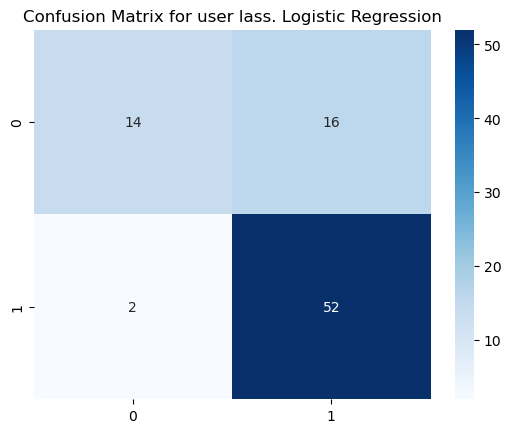

In [56]:
evaluate_model(best_reg, prep, "lass","Logistic Regression")

Fitting 4 folds for each of 25 candidates, totalling 100 fits


              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.89      1.00      0.94        54

    accuracy                           0.92        84
   macro avg       0.94      0.88      0.90        84
weighted avg       0.93      0.92      0.91        84



<AxesSubplot: title={'center': 'Confusion Matrix for user lass. Random Forest'}>

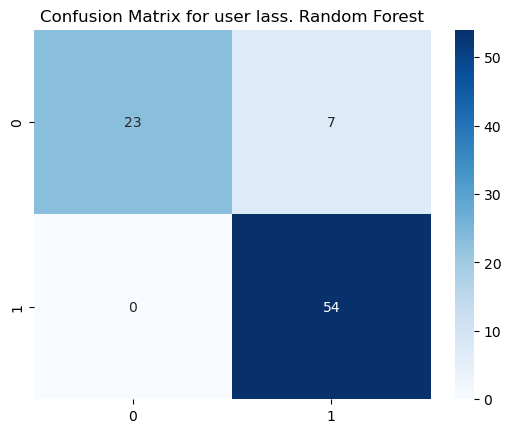

In [57]:
# quick comparison with tree

from UpStraight_Train import train_user_tree_cv

tree = train_user_tree_cv(prep, "lass")
best_tree = tree.best_estimator_

evaluate_model(best_tree, prep, "lass", "Random Forest")

In [50]:
# try a SVM

def train_user_svm_cv(prep, source, target_weight = 0.7, test_size = 0.2):
    y = prep["posture"]
    X = prep.drop("posture",axis=1)
    # map source to 1 else 0
    X["source"] = X["source"].map(lambda x: 1 if x==source else 0)
    # param grid for log reg
    param_grid = {"pca__n_components": [2,5,8],"clf__kernel":["linear","rbf","poly"], "clf__C": [0.001,0.1,1,10,1000]}
    custom_cv = StratifiedShuffleSplit(n_splits=4,test_size=test_size,random_state=42)
    # use source as additional variable in making splits to ensure that source data points are in each split
    y_stratification = pd.concat([y,X["source"]],axis=1)
    splits = custom_cv.split(X,y_stratification)
    rf_grid = GridSearchCV(Pipeline([("col_selector",ColumnSelector(columns=training_columns)),("scaler",StandardScaler()),("pca", PCA()),("clf",SVC())]),param_grid=param_grid,cv=splits,verbose=1,n_jobs=-1)
    rf_results = rf_grid.fit(X,y,clf__sample_weight= get_training_weights(X,target=target_weight))
    return rf_results


In [51]:
svc = train_user_svm_cv(prep, "lass")

Fitting 4 folds for each of 45 candidates, totalling 180 fits


In [52]:
best_svc = svc.best_estimator_
best_svc.get_params()

{'memory': None,
 'steps': [('col_selector',
   ColumnSelector(columns=['hour', 'HeartRate_15_mean', 'HeartRate_15_max',
                           'HeartRate_15_min', 'HeartRate_15_std',
                           'HeartRate_15_range', 'ActiveEnergyBurned_15_mean',
                           'ActiveEnergyBurned_15_max',
                           'ActiveEnergyBurned_15_min',
                           'ActiveEnergyBurned_15_std',
                           'ActiveEnergyBurned_15_range', 'AppleStandTime_15_mean',
                           'AppleStandTime_15_max', 'AppleStandTime_15_min',
                           'Appl...
                           'ActiveEnergyBurned_15_ar1_coef', 'HeartRate_30_mean',
                           'HeartRate_30_max', 'HeartRate_30_min',
                           'HeartRate_30_std', 'HeartRate_30_range',
                           'ActiveEnergyBurned_30_mean',
                           'ActiveEnergyBurned_30_max',
                           'ActiveEne

              precision    recall  f1-score   support

           0       0.89      0.53      0.67        30
           1       0.79      0.96      0.87        54

    accuracy                           0.81        84
   macro avg       0.84      0.75      0.77        84
weighted avg       0.82      0.81      0.80        84



<AxesSubplot: title={'center': 'Confusion Matrix for user lass. SVM'}>

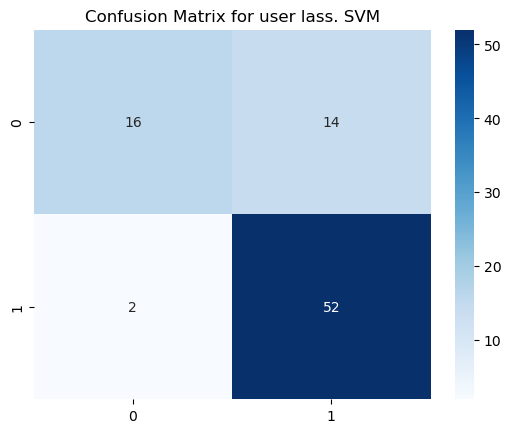

In [58]:
evaluate_model(best_svc, prep, "lass", "SVM")

**Summary**

The other models do not come close to the tree. The tree is the best model for this data set in terms of accuracy.

It is also easy to train since it requires fewer pipelines steps, and is the quickest to train.

*Note: Could also train KNN but would need custom distance function depending on source, replacing the sample_weights during fit.*